## Projeto Final da disciplina de Sistema de Tempo Real
### Escalonador de Tarefas usando os algoritmos Rate Monotonic e Earliest Deadline First

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np

In [2]:
### Classes para o gerenciamento da simulação
class Task:
    def __init__(self, identificador, periodo, tempo_execucao, tempo_chegada):
        self.identificador = identificador
        self.prioridade = 0
        self.periodo = periodo
        self.deadline = periodo+tempo_chegada
        self.tempo_execucao = tempo_execucao
        self.tempo_chegada = tempo_chegada
        self.evento_ativacao = 0
        self.evento_termino = 0
        self.tempo_restante = 0
        self.taxa_utilizacao = 0
            
    def executa_task(self, tempo_atual):
        if self.tempo_restante == 0:
            self.tempo_restante = self.tempo_execucao
            self.evento_termino = tempo_atual+self.tempo_execucao
            self.evento_ativacao = self.deadline
            #print(f'{tempo_atual}: Task {self.identificador} inicia - Tempo de Execução: {self.tempo_restante}')
        else:
            self.evento_termino = tempo_atual+self.tempo_restante
            #print(f'{tempo_atual}: Task {self.identificador} inicia - Tempo de Execução: {self.tempo_restante}')
    
    def preempta_task(self, tempo_atual):
        self.tempo_restante = self.evento_termino - tempo_atual
        self.evento_termino = tempo_atual
        print(f'Tempo {tempo_atual}: Task {self.identificador} é interrompida')
        
    def finaliza_task(self, tempo_atual, edf=False):
        self.tempo_restante = 0
        self.deadline+= self.periodo
        if edf:
            self.prioridade = self.deadline
        #print(f'{tempo_atual}: Task {self.identificador} finaliza')
        
    def set_rate_task(self):
        self.taxa_utilizacao = self.tempo_execucao/self.periodo
        
    def print(self):
        print(f"Identificador: {self.identificador}")
        print(f"Prioridade: {self.prioridade}")
        print(f"Periodo: {self.periodo}")
        print(f"Deadline: {self.deadline}")
        print(f"Tempo de Execucao: {self.tempo_execucao}")
        print(f"Tempo de Chegada: {self.tempo_chegada}")
        print(f"Evento de Ativacao: {self.evento_ativacao}")
        print(f"Evento de Termino: {self.evento_termino}")
        print(f"Tempo de Execucao Restante: {self.tempo_restante}")
        print(f"Taxa de Utilizacao: {self.taxa_utilizacao}")
        print()
        
class PriorityQueue:
    def __init__(self):
        self.queue = [];
        
    def put(self, priority, item):
        self.queue.append((priority, item))
        self.queue.sort(key=lambda x: x[0])
        
    def get(self):
        if not self.empty():
            _, item = self.queue.pop(0)
            return item
        else:
            return None
    
    def get_maior_prioridade(self):
        if not self.empty():
            prioridade, _ = self.queue[0]
            return prioridade
        else:
            return None
            
    def get_id_maior_prioridade(self):
        if not self.empty():
            _, item = self.queue[0]
            return item
        else:
            return None
    
    def empty(self):
        return len(self.queue) == 0
    
    def update(self, item, new_priority):
        for i, (priority, t) in enumerate(self.queue):
            if t == item:
                self.queue[i] = (new_priority, t)
                self.queue.sort(key=lambda x: x[0])
                break
    
class Job:
    def __init__(self, task, tempo_atual):
        self.identificador = task.identificador
        self.prioridade = task.prioridade
        self.inicio = tempo_atual
        self.termino = task.evento_termino
        self.deadline = task.deadline
        self.preempcao = False
        self.atrasado = False
        
    def print(self):
        print(f"Identificador: {self.identificador}")
        print(f"Prioridade: {self.prioridade}")
        print(f"Inicio: {self.inicio}")
        print(f"Termino: {self.termino}")
        print(f"Deadline: {self.deadline}")
        print(f"Preempcao: {self.preempcao}")
        print(f"Atrasado: {self.atrasado}")
        print()
    
class Schedule:
    def __init__(self, tempo_simulacao):
        self.queue = [];
        self.current_time = 0
        self.tempo_simulacao = tempo_simulacao
        
    def put(self, job):
        if not self.miss_deadline(job):
            self.queue.append(job)
        else:
            self.queue.append(job)
            #self.tempo_simulacao = job.termino
            print(f'Tempo {self.current_time}: Job {job.identificador} perde o deadline')
            
        
    def get(self):
        if not self.empty():
            return self.queue.pop(0)
        else:
            return None
        
    def job_em_execucao(self):
        if not self.empty():
            return self.queue[-1]
        else:
            return None
    
    def miss_deadline(self, job):
        if job.termino <= job.deadline:
            return False
        else:
            job.atrasado = True
            return True
        
    def empty(self):
        return len(self.queue) == 0
    
    def print(self):
        for job in self.queue:
            job.print()
            
            
### Funções utilitárias

def get_task_por_identificador(identificador, fila_tasks):
    for task in fila_tasks:
        if (identificador == task.identificador):
            return task
    return None

def calculate_rate_processor(tasks):
    rate_processor = 0
    for task in tasks:
        rate_processor += task.taxa_utilizacao
    return rate_processor
    
def check_schedulability (rate_processor, tasks):
    #print(len(tasks)*(pow(2,1/len(tasks))-1))
    if rate_processor <= len(tasks)*(pow(2,1/len(tasks))-1):
        print("O conjunto de tarefas é escalonavel por RM")
    else:
        print("O conjunto de tarefas não é escalonavel por RM")

In [3]:
## Algoritmo para escalonamento com Rate Monotonic
def rate_monotonic(tasks, tempo_simulacao):
    fila_de_pronto = PriorityQueue()
    fila_evento_ativacao = PriorityQueue()
    escalonamento = Schedule(tempo_simulacao)
    processador_livre = True
    evento_termino_atual = 0
    
    ### Inicializa Valores e coloca na fila de prioridade de acordo com o período
    ### Menor período maior prioriade
    for task in tasks:
        task.set_rate_task()
        task.prioridade = task.periodo
        fila_de_pronto.put(task.prioridade, task.identificador)
        fila_evento_ativacao.put(task.evento_ativacao+task.periodo, task.identificador)
    
    ### Verifica a escalabilidade do algortimo em relação ao conjunto de tarefas
    taxa_processador = calculate_rate_processor(tasks)
    print("************************************************************")
    print("Taxa de utilizacao do processador: " + str(taxa_processador))
    check_schedulability(taxa_processador, tasks)
    print("************************************************************")
    print()
                
    while evento_termino_atual < escalonamento.tempo_simulacao:                     
        
        ### Pega a task de maior prioridade da fila de prontos
        id_task_atual = fila_de_pronto.get()
        task_atual = get_task_por_identificador(id_task_atual, tasks)
        
        if task_atual != None:            
            if processador_livre:
                ### Inicia a execução de um novo Job
                # Registra a execução da Task de mais prioridade da fila de pronto
                escalonamento.current_time = task_atual.evento_ativacao
                task_atual.executa_task(escalonamento.current_time)
                # Insere o Job no escalonamento
                escalonamento.put(Job(task_atual,escalonamento.current_time))
                processador_livre = False
              
            elif not processador_livre:
                ### Condições para a execução com o processador ocupado
                # Verifica condição para preempção de uma task pela próxima
                if task_atual.prioridade < escalonamento.job_em_execucao().prioridade:
                    # Se ocorrer preepção
                    # O tempo atual será o deadline da Task aguardando a execução
                    escalonamento.current_time = task_atual.evento_ativacao
                    ## Atualiza os paramentros para registras a preempção no objeto Job a Task
                    # Aponta para o Job em execução
                    job_executando = escalonamento.job_em_execucao()
                    # Atualiza o termino do Job para o tempo da preempcao
                    job_executando.termino = escalonamento.current_time
                    # Sinaliza a preempcao
                    job_executando.preempcao = True
                    ## Busca a task pelo Id do Job
                    task_executando = get_task_por_identificador(job_executando.identificador, tasks)
                    # Sinaliza a preempção no objeto Task
                    task_executando.preempta_task(escalonamento.current_time)
                                        
                    ### Recoloca a tarefa preemptada na fila de prontos
                    fila_de_pronto.put(task_executando.prioridade, task_executando.identificador)
    
                    ### Inicia a execução de um novo Job
                    task_atual.executa_task(escalonamento.current_time)
                    escalonamento.put(Job(task_atual,escalonamento.current_time))
                    processador_livre = False
                    evento_termino_atual = task_atual.evento_termino
                else:
                    ### Registra a finalização do Job atual
                    # Aponta para o Job em execução
                    job_executando = escalonamento.job_em_execucao()
                    # Atualiza o current time para o tempo de finalização do Job
                    escalonamento.current_time = job_executando.termino
                    # Busca a Task do Job em execução pelo Id
                    task_executando = get_task_por_identificador(job_executando.identificador, tasks)
                    # Finaliza a execução
                    task_executando.finaliza_task(escalonamento.current_time)
                    
                    ### Inicia a execução de um novo Job
                    # Registra a execução da Task de mais prioridade da fila de pronto
                    task_atual.executa_task(escalonamento.current_time)
                    # Insere o Job no escalonamento
                    escalonamento.put(Job(task_atual,escalonamento.current_time))
                    processador_livre = False
                    evento_termino_atual = task_atual.evento_termino

            ### Atualiza fila de eventos de ativação
            fila_evento_ativacao.update(task_atual.identificador, task_atual.evento_ativacao)
            ### Atualiza fila de prontos
            if escalonamento.job_em_execucao().termino > fila_evento_ativacao.get_maior_prioridade():
                # busca a do proximo evento de ativacao tasks na lista de tasks
                id_task = fila_evento_ativacao.get_id_maior_prioridade()
                task = get_task_por_identificador(id_task, tasks)
                # coloca task na fila de prontos
                fila_de_pronto.put(task.prioridade, task.identificador)
                #print(f'{escalonamento.current_time}: Task {task.identificador} volta pra fila de prontos')
        
        # Se não tiver task na fila de prontos
        else:
            ### Registra a finalização do Job atual
            # Aponta para o Job em execução
            job_executando = escalonamento.job_em_execucao()
            # Atualiza o current time para o tempo de finalização do Job
            escalonamento.current_time = job_executando.termino
            # Busca a Task do Job em execução pelo Id
            task_executando = get_task_por_identificador(job_executando.identificador, tasks)
            # Finaliza a execução
            task_executando.finaliza_task(escalonamento.current_time)
             
            processador_livre = True
            
            ### Atualiza fial de pronto
            fila_de_pronto.put(tasks[0].prioridade, tasks[0].identificador)
             
            
    return escalonamento                 

In [4]:
## Algoritmo para escalonamento com EDF
def edf(tasks, tempo_simulacao):
    fila_de_pronto = PriorityQueue()
    fila_evento_ativacao = PriorityQueue()
    escalonamento = Schedule(tempo_simulacao)
    processador_livre = True
    evento_termino_atual = 0
    
    ### Inicializa Valores e coloca na fila de prioridade de acordo com o deadline
    ### Menor deadline maior prioriade
    for task in tasks:
        task.prioridade = task.deadline
        fila_de_pronto.put(task.prioridade, task.identificador)
        fila_evento_ativacao.put(task.evento_ativacao+task.periodo, task.identificador)
                       
    while evento_termino_atual < escalonamento.tempo_simulacao:                     
        
        ### Pega a task de maior prioridade da fila de prontos
        # utiliza o id como ponteiro para o objeto da task
        id_task_atual = fila_de_pronto.get()
        task_atual = get_task_por_identificador(id_task_atual, tasks)
        
        if task_atual != None:            
            if processador_livre:
                ### Inicia a execução de um novo Job
                # Registra a execução da Task de mais prioridade da fila de pronto
                escalonamento.current_time = task_atual.evento_ativacao
                task_atual.executa_task(escalonamento.current_time)
                # Insere o Job no escalonamento
                escalonamento.put(Job(task_atual,escalonamento.current_time))
                processador_livre = False
              
            elif not processador_livre:
                ### Condições para a execução com o processador ocupado
                # Verifica condição para preempção de uma task pela próxima
                if task_atual.deadline < escalonamento.job_em_execucao().prioridade:
                    # Se ocorrer preepção
                    # O tempo atual será o deadline da Task aguardando a execução
                    escalonamento.current_time = task_atual.evento_ativacao
                    ## Atualiza os paramentros para registras a preempção no objeto Job a Task
                    # Aponta para o Job em execução
                    job_executando = escalonamento.job_em_execucao()
                    # Atualiza o termino do Job para o tempo da preempcao
                    job_executando.termino = escalonamento.current_time
                    # Sinaliza a preempcao
                    job_executando.preempcao = True
                    ## Busca a task pelo Id do Job
                    task_executando = get_task_por_identificador(job_executando.identificador, tasks)
                    # Sinaliza a preempção no objeto Task
                    task_executando.preempta_task(escalonamento.current_time)
                                        
                    ### Recoloca a tarefa preemptada na fila de prontos
                    fila_de_pronto.put(task_executando.prioridade, task_executando.identificador)
    
                    ### Inicia a execução de um novo Job
                    task_atual.executa_task(escalonamento.current_time)
                    escalonamento.put(Job(task_atual,escalonamento.current_time))
                    processador_livre = False
                    evento_termino_atual = task_atual.evento_termino
                else:
                    ### Registra a finalização do Job atual
                    # Aponta para o Job em execução
                    job_executando = escalonamento.job_em_execucao()
                    # Atualiza o current time para o tempo de finalização do Job
                    escalonamento.current_time = job_executando.termino
                    # Busca a Task do Job em execução pelo Id
                    task_executando = get_task_por_identificador(job_executando.identificador, tasks)
                    # Finaliza a execução
                    task_executando.finaliza_task(escalonamento.current_time, edf=True)
                    
                    ### Inicia a execução de um novo Job
                    # Registra a execução da Task de mais prioridade da fila de pronto
                    task_atual.executa_task(escalonamento.current_time)
                    # Insere o Job no escalonamento
                    escalonamento.put(Job(task_atual,escalonamento.current_time))
                    processador_livre = False
                    evento_termino_atual = task_atual.evento_termino

            ### Atualiza fila de eventos de ativação
            fila_evento_ativacao.update(task_atual.identificador, task_atual.evento_ativacao)
            ### Atualiza fila de prontos
            if escalonamento.job_em_execucao().termino > fila_evento_ativacao.get_maior_prioridade():
                # busca a do proximo evento de ativacao tasks na lista de tasks
                id_task = fila_evento_ativacao.get_id_maior_prioridade()
                task = get_task_por_identificador(id_task, tasks)
                # coloca task na fila de prontos
                fila_de_pronto.put(task.prioridade, task.identificador)
                #print(f'{escalonamento.current_time}: Task {task.identificador} volta pra fila de prontos')
        
        # Se não tiver task na fila de prontos
        else:
            ### Registra a finalização do Job atual
            # Aponta para o Job em execução
            job_executando = escalonamento.job_em_execucao()
            # Atualiza o current time para o tempo de finalização do Job
            escalonamento.current_time = job_executando.termino
            # Busca a Task do Job em execução pelo Id
            task_executando = get_task_por_identificador(job_executando.identificador, tasks)
            # Finaliza a execução
            task_executando.finaliza_task(escalonamento.current_time, edf=True)
             
            processador_livre = True
            
            ### Atualiza fial de pronto
            fila_de_pronto.put(tasks[0].prioridade, tasks[0].identificador)
             
            
    return escalonamento   

In [5]:
## Função para plot do gráfico
def plot_escalonamento(escalonamento, tipo, intervalo):
    cores = {1: 'tab:blue', 2: 'tab:gray', 3: 'tab:olive', 4: 'tab:pink', 5: 'tab:cyan'}

    fig, ax = plt.subplots(figsize=(12, 2))

    for job in escalonamento.queue:
        start = job.inicio
        duration = job.termino - job.inicio
        if not job.atrasado:
            ax.barh(job.identificador, duration, left=start, color=cores[job.identificador])
        else:
            ax.barh(job.identificador, duration, left=start, color='tab:red')
        # Plota as linhas de deadline
        if job.deadline<escalonamento.tempo_simulacao+1:
            ax.axvline(x=job.deadline, color=cores[job.identificador], linestyle='--', 
                       linewidth=2, ymax=len(tasks))
        

    y_values = np.arange(1, len(tasks)+1)
    ax.set_yticks(y_values)
    x_values = np.arange(0, escalonamento.tempo_simulacao+1, intervalo)
    ax.set_xticks(x_values)
    ax.set_xlim(right=escalonamento.tempo_simulacao+5)
    if tipo == 'rm':
        ax.set_title('Escalonamento por Rate Monotonic')
    elif tipo == 'edf':
        ax.set_title('Escalonamento por EDF')
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    

    plt.show()

## Casos de teste

### Caso 1

In [20]:
tasks = [Task(identificador=1, periodo=5, tempo_execucao=3, tempo_chegada=0), 
        Task(identificador=2, periodo=7, tempo_execucao=4, tempo_chegada=0),
        Task(identificador=3, periodo=10,tempo_execucao=6, tempo_chegada=0)]

tempo_simulacao = 20
escalonamento = rate_monotonic(tasks, tempo_simulacao)

************************************************************
Taxa de utilizacao do processador: 1.7714285714285714
O conjunto de tarefas não é escalonavel por RM
************************************************************

Tempo 5: Task 2 é interrompida
Tempo 8: Job 2 perde o deadline
Tempo 10: Task 2 é interrompida
Tempo 13: Job 2 perde o deadline


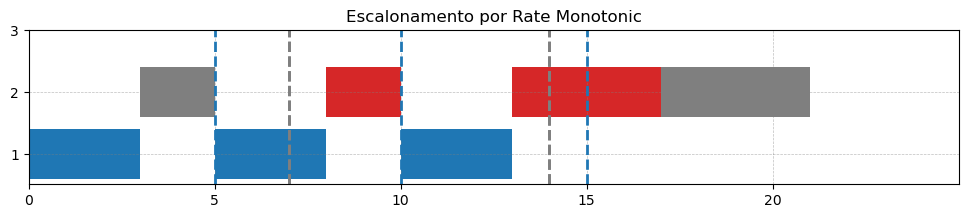

In [21]:
plot_escalonamento(escalonamento, 'rm', 5)

### Caso 2

In [10]:
tasks = [Task(identificador=1, periodo=100, tempo_execucao=20, tempo_chegada=0), 
         Task(identificador=2, periodo=150, tempo_execucao=40, tempo_chegada=0), 
         Task(identificador=3, periodo=350, tempo_execucao=100,tempo_chegada=0)]

tempo_simulacao = 360
escalonamento = rate_monotonic(tasks, tempo_simulacao)

************************************************************
Taxa de utilizacao do processador: 0.7523809523809524
O conjunto de tarefas é escalonavel por RM
************************************************************

Tempo 100: Task 3 é interrompida
Tempo 150: Task 3 é interrompida
Tempo 200: Task 3 é interrompida


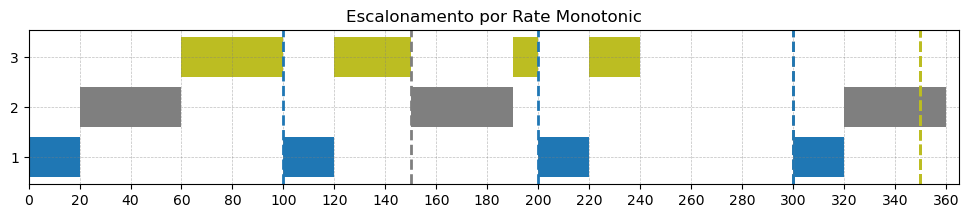

In [11]:
plot_escalonamento(escalonamento, 'rm', 20)

In [12]:
tasks = [Task(identificador=1, periodo=100, tempo_execucao=20, tempo_chegada=0), 
         Task(identificador=2, periodo=150, tempo_execucao=40, tempo_chegada=0), 
         Task(identificador=3, periodo=350, tempo_execucao=100,tempo_chegada=0)]

tempo_simulacao = 360
escalonamento = edf(tasks, tempo_simulacao)

Tempo 100: Task 3 é interrompida
Tempo 150: Task 3 é interrompida
Tempo 200: Task 3 é interrompida


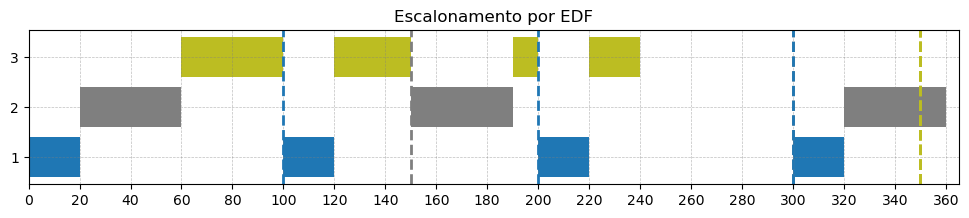

In [13]:
plot_escalonamento(escalonamento, 'edf',  20)

In [14]:
escalonamento.print()

Identificador: 1
Prioridade: 100
Inicio: 0
Termino: 20
Deadline: 100
Preempcao: False
Atrasado: False

Identificador: 2
Prioridade: 150
Inicio: 20
Termino: 60
Deadline: 150
Preempcao: False
Atrasado: False

Identificador: 3
Prioridade: 350
Inicio: 60
Termino: 100
Deadline: 350
Preempcao: True
Atrasado: False

Identificador: 1
Prioridade: 200
Inicio: 100
Termino: 120
Deadline: 200
Preempcao: False
Atrasado: False

Identificador: 3
Prioridade: 350
Inicio: 120
Termino: 150
Deadline: 350
Preempcao: True
Atrasado: False

Identificador: 2
Prioridade: 300
Inicio: 150
Termino: 190
Deadline: 300
Preempcao: False
Atrasado: False

Identificador: 3
Prioridade: 350
Inicio: 190
Termino: 200
Deadline: 350
Preempcao: True
Atrasado: False

Identificador: 1
Prioridade: 300
Inicio: 200
Termino: 220
Deadline: 300
Preempcao: False
Atrasado: False

Identificador: 3
Prioridade: 350
Inicio: 220
Termino: 240
Deadline: 350
Preempcao: False
Atrasado: False

Identificador: 1
Prioridade: 400
Inicio: 300
Termino: 3

### Caso 3

In [15]:
tasks = [Task(identificador=1, periodo=20, tempo_execucao=10, tempo_chegada=0), 
         Task(identificador=2, periodo=50, tempo_execucao=25, tempo_chegada=0)]

tempo_simulacao = 60
escalonamento = rate_monotonic(tasks, tempo_simulacao)

************************************************************
Taxa de utilizacao do processador: 1.0
O conjunto de tarefas não é escalonavel por RM
************************************************************

Tempo 20: Task 2 é interrompida
Tempo 40: Task 2 é interrompida
Tempo 50: Job 2 perde o deadline


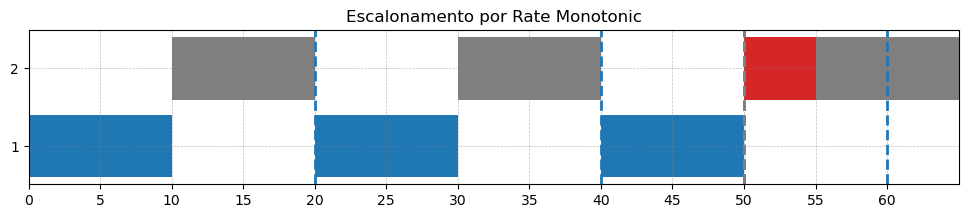

In [16]:
plot_escalonamento(escalonamento, 'rm', 5)

In [17]:
# Caso 3
tasks = [Task(identificador=1, periodo=20, tempo_execucao=10, tempo_chegada=0), 
         Task(identificador=2, periodo=50, tempo_execucao=25, tempo_chegada=0)]

tempo_simulacao = 60
escalonamento = edf(tasks, tempo_simulacao)

Tempo 20: Task 2 é interrompida


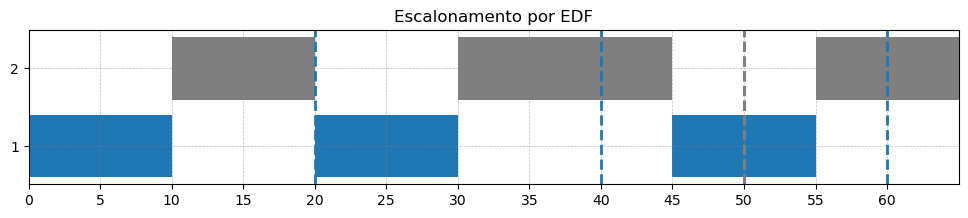

In [18]:
plot_escalonamento(escalonamento, 'edf', 5)

In [19]:
# Verificação da prioridade dinâmica
escalonamento.print()

Identificador: 1
Prioridade: 20
Inicio: 0
Termino: 10
Deadline: 20
Preempcao: False
Atrasado: False

Identificador: 2
Prioridade: 50
Inicio: 10
Termino: 20
Deadline: 50
Preempcao: True
Atrasado: False

Identificador: 1
Prioridade: 40
Inicio: 20
Termino: 30
Deadline: 40
Preempcao: False
Atrasado: False

Identificador: 2
Prioridade: 50
Inicio: 30
Termino: 45
Deadline: 50
Preempcao: False
Atrasado: False

Identificador: 1
Prioridade: 60
Inicio: 45
Termino: 55
Deadline: 60
Preempcao: False
Atrasado: False

Identificador: 2
Prioridade: 100
Inicio: 55
Termino: 80
Deadline: 100
Preempcao: False
Atrasado: False

